# Computational Inteligence Project phase 1

Faridreza Momtazzandi 9812762601

In this phase, we first get to know a pretty clean and ready-to-use dataset which is an EEG signals dataset for seizure detection in epileptic patients. This phase has two main parts, first, we'll start working on feature engineering and after that, we get to use the features we got on some classification algorithms.

Let's start by bringing in all the libraries we're gonna need! In this project, we'll mostly use the NumPy and sklearn libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statistics import mean
import numpy as np
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, accuracy_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, lfilter
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import scipy.stats as sp
import random
import os

As we learned in the project overview session we're facing a data set with a huge amount of records so our solution to use this dataset efficiently is to make it a pickle we already did so in the next part we try to extract our desired data from the pickle.

In [ ]:
seed = 57

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


x = pickle.load(open(
    x.pkl', 'rb'))
y = pickle.load(open('/content/drive/MyDrive/CI/y.pkl', 'rb'))

x_normal = np.concatenate((x[:300], x[400:]), axis=0)
x_seizure = x[300:400]
sampling_freq = 173.6 #based on info from website

b, a = butter(3, [0.5,40], btype='bandpass',fs=sampling_freq)


x_normal_filtered = np.array([lfilter(b,a,x_normal[ind,:]) for ind in range(x_normal.shape[0])])
x_seizure_filtered = np.array([lfilter(b,a,x_seizure[ind,:]) for ind in range(x_seizure.shape[0])])

x_normal = x_normal_filtered
x_seizure = x_seizure_filtered

x = np.concatenate((x_normal,x_seizure))
y = np.concatenate((np.zeros((400,1)),np.ones((100,1))))

Later on, we'll see for making our classification algorithms faster we need to normalize our features which we'll do it by the normalize function down below.

In [ ]:
def normalize (x):
    norm = np.linalg.norm(x)
    x = x / norm
    return x

Now we're gonna get our features by using mostly three groups of feature engineering Statistical, Time domain, and Frequency domain. Features we have are absolute max, mean, median, variance, standard deviation, ptp, skew, kurtosis, RMS, crest factor margin, margin factor, A factor values, and B factor values.

In [ ]:
#calculating absolute max values:
abs_max_values = np.zeros((500,1))
mean_values = np.zeros((500, 1))
median_values = np.zeros((500,1))
variance_values = np.zeros((500,1))
standard_deviation = np.zeros((500,1))
ptp = np.zeros((500,1))
skew_values = np.zeros((500,1))
kurtosis_values = np.zeros((500, 1))
RMS_values = np.zeros((500,1))

i = 0
for row in x:
    abs_max_values[i][0] = max(row)
    mean_values[i][0] = np.mean(row)
    median_values[i][0] = np.median(row)
    variance_values[i][0] = np.var(row)
    standard_deviation[i][0] = np.std(row)
    ptp[i][0] = np.ptp(row)
    skew_values[i][0] = sp.skew(row)
    kurtosis_values[i][0] = sp.kurtosis(row)
    RMS_values[i][0] = np.sqrt(np.mean(row ** 2))
    i += 1
    
abs_max_values = normalize(abs_max_values)
mean_values = normalize(mean_values)
median_values = normalize(median_values)
variance_values = normalize(variance_values)
standard_deviation = normalize(standard_deviation)
ptp = normalize(ptp)
skew_values = normalize(skew_values)
kurtosis_values = normalize(kurtosis_values)
RMS_values = normalize(RMS_values)

crest_factor_margin = np.zeros((500, 1))
margin_factor = np.zeros((500,1))
A_factor_values = np.zeros((500,1))
B_factor_values = np.zeros((500,1))

for i in range (0, 500):
    crest_factor_margin[i][0] = abs_max_values[i][0] / RMS_values[i][0]
    margin_factor[i][0] = abs_max_values[i][0] / variance_values[i][0]
    A_factor_values[i][0] = abs_max_values[i][0] / (standard_deviation[i][0] * variance_values[i][0])
    B_factor_values[i][0] = (kurtosis_values[i][0] * crest_factor_margin[i][0]) / standard_deviation[i][0]

crest_factor_margin = normalize(crest_factor_margin)
margin_factor = normalize(margin_factor)
A_factor_values = normalize(A_factor_values)
B_factor_values = normalize(B_factor_values)

After getting all these features we need to concatiate all of them so we can use them all for our cliassification methods.

In [ ]:
x = np.concatenate((mean_values, abs_max_values, median_values, variance_values, standard_deviation, ptp, skew_values,kurtosis_values,RMS_values, A_factor_values, B_factor_values, crest_factor_margin, margin_factor), 1)
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=seed,test_size=0.2 )

We finally finished the first part of our project and are ready to use our features. We start by implementing svc and use different kernels so we can get a full understanding of how better each kernel works for us.

In [ ]:
clf = SVC(kernel='linear')
clf.fit(x_train, np.ravel(y_train))

y_pred = clf.predict(x_test)

print("SVC with linear kernel: ")
print("SVC accuracy: ", accuracy_score(y_test,y_pred))
print("SVC precision: ", precision_score(y_test,y_pred))
print("SVC recall: ", recall_score(y_test,y_pred))

print("cross validation for this clf: ", cross_val_score(clf, x, np.ravel(y), cv = 5))

clf = SVC(kernel='sigmoid')
clf.fit(x_train, np.ravel(y_train))

y_pred = clf.predict(x_test)

print("SVC using sigmoid kernel")
print("SVC accuracy", accuracy_score(y_test,y_pred))
print("SVC precision", accuracy_score(y_test,y_pred))
print("SVC recall", accuracy_score(y_test,y_pred))

print("cross validation for this clf: ", cross_val_score(clf, x, np.ravel(y), cv = 5))


clf = SVC(kernel='rbf')
clf.fit(x_train, np.ravel(y_train))

y_pred = clf.predict(x_test)

print("SVC using rbf kernel: ")
print("SVC accuracy: ", accuracy_score(y_test,y_pred))
print("SVC precision: ", precision_score(y_test,y_pred))
print("SVC recall: ", recall_score(y_test,y_pred))

print("cross validation for this clf: ", cross_val_score(clf, x, np.ravel(y), cv = 5))


clf = SVC(kernel='poly')
clf.fit(x_train, np.ravel(y_train))

y_pred = clf.predict(x_test)

print("SVC using poly kernel: ")
print("SVC accuracy: ", accuracy_score(y_test,y_pred))
print("SVC precision: ", precision_score(y_test,y_pred))
print("SVC recall: ", recall_score(y_test,y_pred))

print("cross validation for this clf: ", cross_val_score(clf, x, np.ravel(y), cv = 5))



SVC with linear kernel: 
SVC accuracy:  0.88
SVC precision:  1.0
SVC recall:  0.5384615384615384
cross validation for this clf:  [0.93 0.89 0.88 0.87 0.88]
SVC using sigmoid kernel
SVC accuracy 0.85
SVC precision 0.85
SVC recall 0.85
cross validation for this clf:  [0.81 0.84 0.86 0.92 0.93]
SVC using rbf kernel: 
SVC accuracy:  0.95
SVC precision:  1.0
SVC recall:  0.8076923076923077
cross validation for this clf:  [0.88 0.96 0.98 0.99 0.98]
SVC using poly kernel: 
SVC accuracy:  0.94
SVC precision:  1.0
SVC recall:  0.7692307692307693
cross validation for this clf:  [0.92 0.97 0.95 0.95 0.97]


Now let's take a look at the random forest method this time we'll run our model with different maximum depths and random states to see how our result will change.

RF with max depth 2and random state 0
RF accuracy:  0.99
RF precision:  1.0
RF recall:  0.9615384615384616
cross validation for RF:  [0.9  0.98 0.98 1.   1.  ] 

RF using max depth 3 and random state 2: 
RF accuracy:  0.99
RF precision:  1.0
RF recall:  0.9615384615384616
cross validation for RF:  [0.9  0.97 0.98 1.   1.  ] 

the confusion matrix for random forest: 
[[74  0]
 [ 1 25]] 



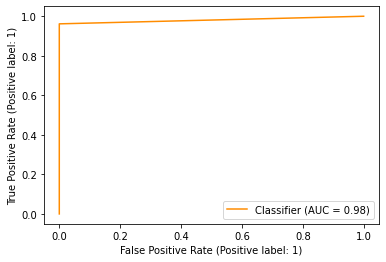

In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state = 0)
rf.fit(x_train, np.ravel(y_train))

y_pred = rf.predict(x_test)

print("RF with max depth 2and random state 0")
print("RF accuracy: ", accuracy_score(y_test, y_pred))
print("RF precision: ", precision_score(y_test, y_pred))
print("RF recall: ", recall_score(y_test, y_pred))

print("cross validation for RF: ", cross_val_score(rf, x, np.ravel(y), cv = 5), "\n")

rf = RandomForestClassifier(max_depth=3, random_state = 2)
rf.fit(x_train, np.ravel(y_train))

y_pred = rf.predict(x_test)

print("RF using max depth 3 and random state 2: ")
print("RF accuracy: ", accuracy_score(y_test, y_pred))
print("RF precision: ", precision_score(y_test, y_pred))
print("RF recall: ", recall_score(y_test, y_pred))

print("cross validation for RF: ", cross_val_score(rf, x, np.ravel(y), cv = 5), "\n")

print("the confusion matrix for random forest: ")
print(confusion_matrix(y_test, y_pred), "\n")

#ROC chart for random forest
RocCurveDisplay.from_predictions(y_test, y_pred, color= "darkorange")
plt.show()

As we see random forest got the best result so we draw the roc curve and get a confusion matrix for it as well.

and for our last classification method, we use knn and we can change the number of neighbors to get different results.

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=50, weights='uniform')
knn.fit(x_train, np.ravel(y_train))

y_pred = knn.predict(x_test)

print("--------------------\n")
print("KNN using 50neighbors and weights uniform: ")
print("KNN accuracy: ", accuracy_score(y_test, y_pred))
print("KNN precision: ", precision_score(y_test, y_pred))
print("KNN recall: ", recall_score(y_test, y_pred))

print("cross validation for KNN: ", cross_val_score(knn, x, np.ravel(y), cv = 5), "\n")

knn = neighbors.KNeighborsClassifier(n_neighbors=25, weights='uniform')
knn.fit(x_train, np.ravel(y_train))

y_pred = knn.predict(x_test)
print("--------------------\n")
print("KNN using 25neighbors and weights uniform: ")
print("KNN accuracy: ", accuracy_score(y_test, y_pred))
print("KNN precision: ", precision_score(y_test, y_pred))
print("KNN recall: ", recall_score(y_test, y_pred))

print("cross validation for KNN: ", cross_val_score(knn, x, np.ravel(y), cv = 5), "\n")


--------------------

KNN using 50neighbors and weights uniform: 
KNN accuracy:  0.9
KNN precision:  1.0
KNN recall:  0.6153846153846154
cross validation for KNN:  [0.94 0.91 0.9  0.89 0.89] 

[0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
--------------------

KNN using 25neighbors and weights uniform: 
KNN accuracy:  0.92
KNN precision:  1.0
KNN recall:  0.6923076923076923
cross validation for KNN:  [0.94 0.95 0.92 0.94 0.92] 



# Conclusion
After finishing this project and learning these new aspects of machine learning we found out methods like normalization might make our program faster but doesn't always make our model more accurate.